# The Application of a Hybrid Garch-type Model with Quantile Regression Neural Network on the Estimation of Value-at-Risk of Corporate Stocks

### Loading Packages

In [ ]:
#36mins
install.packages("fGarch")
install.packages("GAS")
install.packages("rugarch")
install.packages('tidyquant')
install.packages('qrnn')
install.packages('Rcpp')
install.packages('xts')
install.packages('zoo')
install.packages('opera')
install.packages(quantmod)
install.packages(dplyr)
library(dplyr)
library(Rcpp)
library(xts)
library(zoo)
library("qrnn")
library("fGarch")
library("GAS")
library("ggplot2")
library("rugarch")
library(tidyr)
library(tidyquant)
library(opera)
library(quantmod)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘gss’, ‘stabledist’, ‘gbutils’, ‘Rdpack’, ‘fBasics’, ‘timeDate’, ‘timeSeries’, ‘fastICA’, ‘cvar’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘Rcpp’, ‘Rsolnp’, ‘xts’, ‘numDeriv’, ‘zoo’, ‘cubature’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘ks’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘later’, ‘listenv’, ‘parallelly’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘furrr’, ‘htmlwi

In [ ]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("AAPL", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)

# Calculating log returns using the Adjusted prices (AAPL.Adjusted)
log_ret <- diff(log(AAPL$AAPL.Adjusted))

log_ret <- as.data.frame(log_ret[2:1299])

[1] "AAPL"

In [ ]:
skewness(log_returns)

[1] -0.256838

In [ ]:
kurtosis(log_returns)

[1] 5.503988

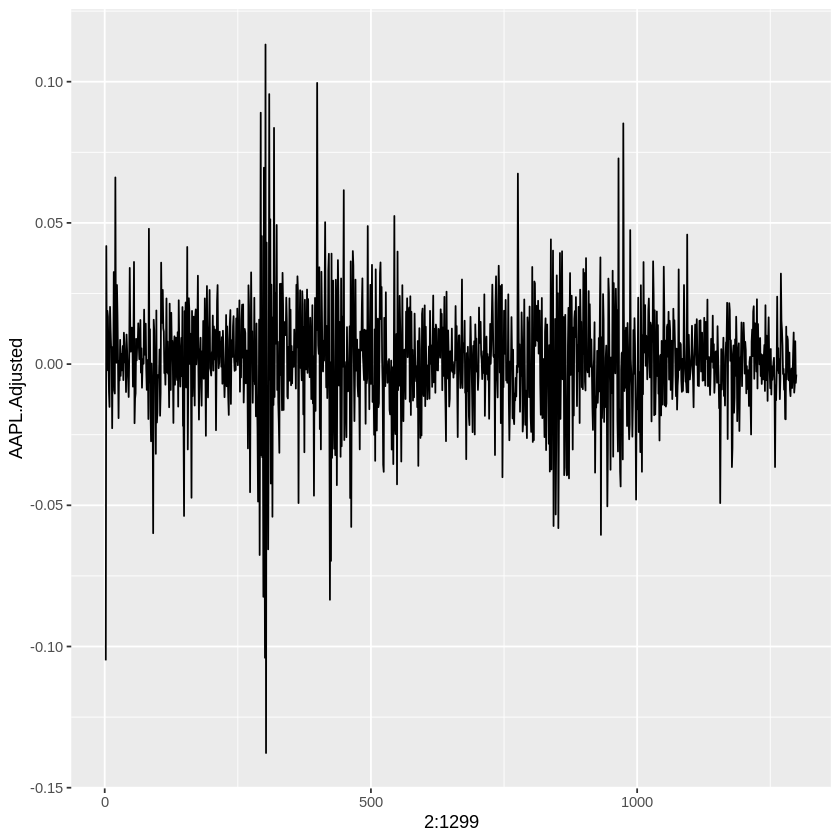

In [ ]:
ggplot(log_returns, aes(x=2:1299,y=AAPL.Adjusted))+
  geom_line()

### Generating Simulation Data

#### Data Set 1: Conditional Distribution: Normal Distribution

In [ ]:
spec_norm = garchSpec(model = list(mu = 1.0e-3, ar = 0.05, omega = 1.0e-6,
alpha = 0.05, gamma = 0, beta = 0.8, delta = 1.8,
shape = 4, skew = 1), cond.dist = "norm")
set.seed(520)
sim_norm = garchSim(spec_norm, n = 1500)
sim_norm = as.data.frame(sim_norm)

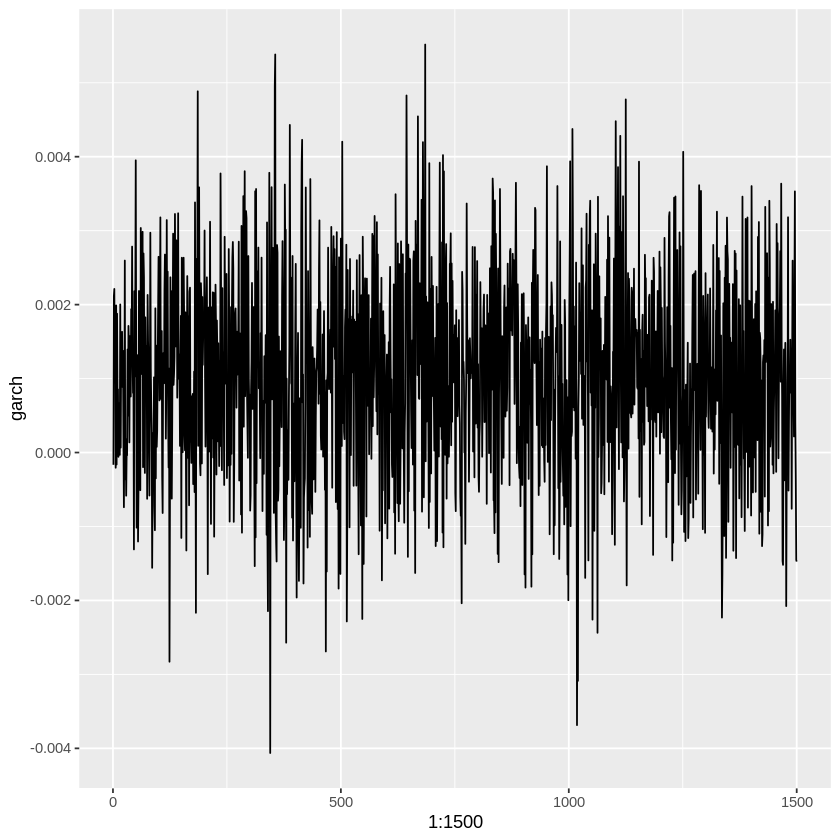

In [ ]:
ggplot(sim_norm, aes(x=1:1500,y=garch))+
  geom_line()

In [ ]:
write.csv(sim_norm,"sim_norm.csv")

#### Data Set 2: Conditional Distribution: Skewed Normal Distribution

In [ ]:
spec_snorm = garchSpec(model = list(mu = 1.0e-3, ar = 0.05, omega = 1.0e-6,
alpha = 0.05, gamma = 0, beta = 0.8, delta = 1.8,
shape = 4, skew = 1), cond.dist = "snorm")
set.seed(520)
sim_snorm = garchSim(spec_snorm, n = 1500)
sim_snorm = as.data.frame(sim_snorm)

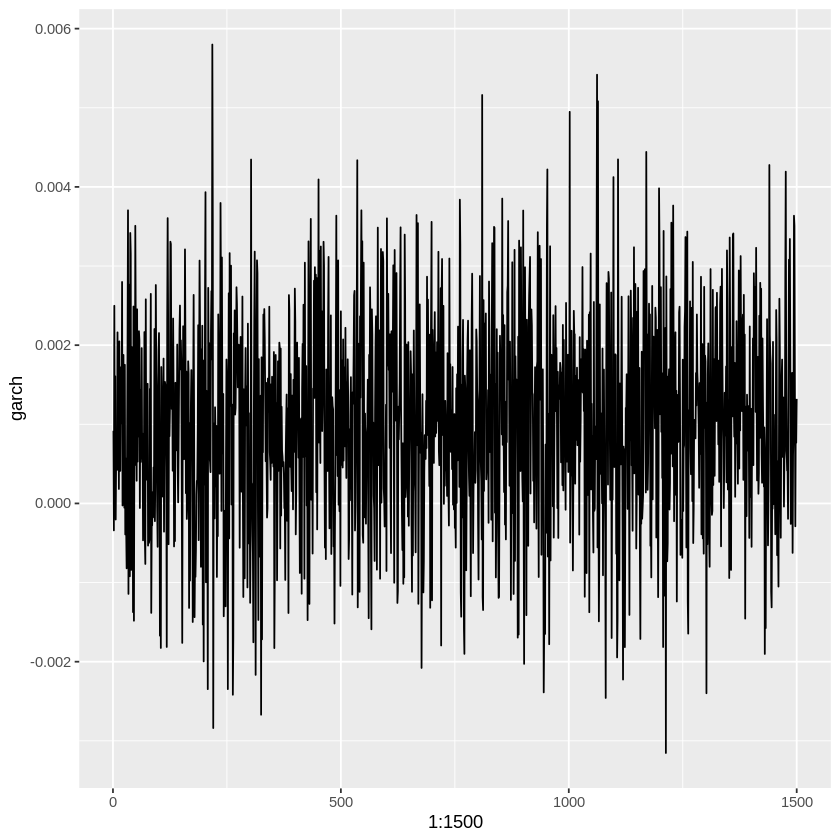

In [ ]:
ggplot(sim_snorm, aes(x=1:1500,y=garch))+
  geom_line()

#### Data Set 3: Conditional Distribution: Student t Distribution

In [ ]:
spec_std = garchSpec(model = list(mu = 1.0e-3, ar = 0.05, omega = 1.0e-6,
alpha = 0.05, gamma = 0, beta = 0.8, delta = 1.8,
shape = 4, skew = 1), cond.dist = "std")
set.seed(520)
sim_std = garchSim(spec_std, n = 1500)
sim_std = as.data.frame(sim_std)

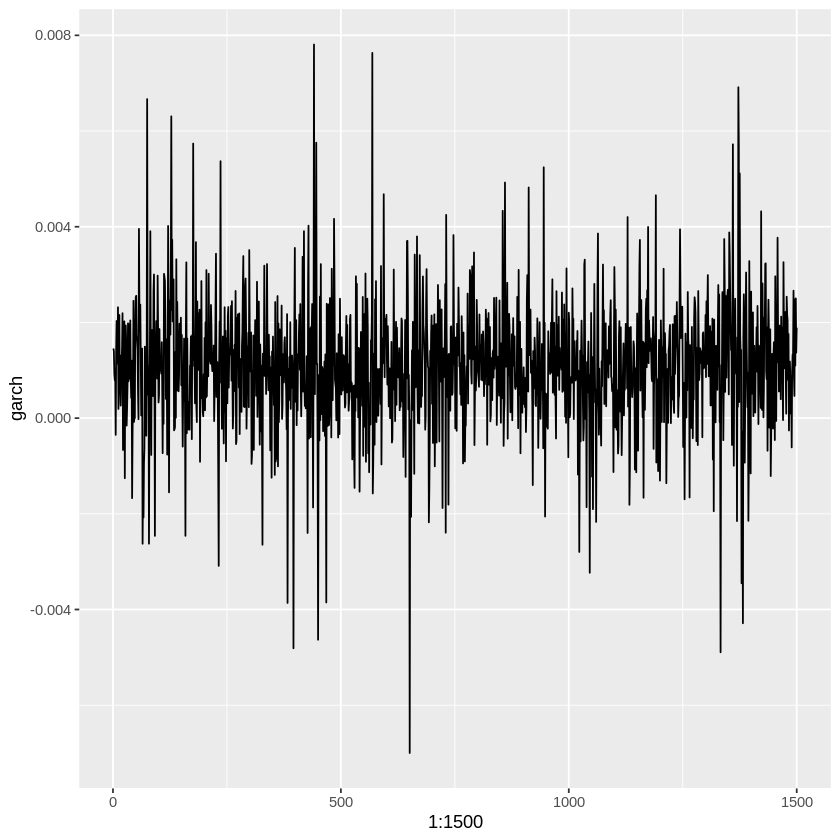

In [ ]:
ggplot(sim_std, aes(x=1:1500,y=garch))+
  geom_line()

### Extracting Empirical Data(AAPL, ALAR, SMTC)

In [ ]:
getSymbols("AAPL", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)

log_ret <- diff(log(AAPL$AAPL.Adjusted))
log_ret <- as.data.frame(log_ret[2:1299])

time_series4 <- log_ret$AAPL.Adjusted


options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("ALAR", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)

log_ret <- diff(log(ALAR$ALAR.Adjusted))
log_ret <- as.data.frame(log_ret[2:1299])

time_series5 <- log_ret$ALAR.Adjusted

options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("SMTC", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)

log_ret <- diff(log(SMTC$SMTC.Adjusted))
log_ret <- as.data.frame(log_ret[2:1299])

time_series6 <- log_ret$SMTC.Adjusted

#### Plot the ACF plots to determine the autoregressive orders

In [ ]:
png('acf2.png')
opar <- par(mfrow = c(2, 3))
acf(sim_norm$garch,lag.max=5,lwd = 2,main='sim_norm')
acf(sim_snorm$garch,lag.max=5,lwd = 2,main='sim_snorm')
acf(sim_std$garch,lag.max=5,lwd = 2,main='sim_std')
acf(time_series4,lag.max=5,lwd = 2,main='AAPL log returns')
acf(time_series5,lag.max=5,lwd = 2,main='ALAR log returns')
acf(time_series6,lag.max=5,lwd = 2,main='SMTC log returns')
par(opar)

dev.off()

#### Plot the squared time series to visualize the unconditional volatility

In [ ]:
df <- data.frame(cbind(time_series4**2, time_series5**2, time_series6**2))
colnames(df) <- c('3:AAPL','1:SMTC','2:ALAR')
cols <- c('AAPL'='blue','SMTC'='green','AAPL'='red')
ggplot(df)+
  geom_line(aes(x=1:1298,y=SMTC),col='blue')+
  geom_line(aes(x=1:1298,y=ALAR),col='green')+
  geom_line(aes(x=1:1298,y=AAPL),col='red')+
  scale_color_manual(values=c('red','blue','green'),labels=c('AAPL','SMTC','ALAR'))+
  theme(legend.position='top')

library(tidyr)
df <- gather(df,key='stocks',value='squared_log_returns')
df['seq'] <- rep(seq(1,1298),3)
gg <-ggplot(df)+
  geom_line(aes(x=seq,y=squared_log_returns,col=stocks))+
  theme_classic()
ggsave('squared log return.png',gg,width=4,height=3)

### Model 1: APARCH

#### Fit on empirical stock returns (SMTC)

In [ ]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("SMTC", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)
log_ret <- diff(log(SMTC$SMTC.Adjusted))
log_ret <- as.data.frame(log_ret[2:1299])

[1] "SMTC"

In [ ]:
skewness(log_returns)

[1] -1.448057

In [ ]:
kurtosis(log_returns)

[1] 14.58161

In [ ]:
#function of fitting aparch model (including model selection, p and q from 1 or 2, conditional distribution choosing from normal to skewed normal to student t)
results_ap <- function(log_returns){
  dfall_ap <- data.frame()
  thetas <- c(0.01,0.05,0.1)
  n <- length(log_returns)

  data=log_returns
  VaR <- list(`0.01` = NULL, `0.05` = NULL, `0.1` = NULL)
  bic <- c()
  for(p in 1:2){
    for(q in 1:2){
      for(dist in c('norm','snorm','std')){
        spec <- ugarchspec(variance.model=list(model="apARCH",garchOrder=c(p,q)),mean.model = list(armaOrder = c(1, 0)),distribution.model = dist)
        bic <- append(bic,infocriteria(ugarchfit(data = data[1:1000], spec = spec,solver='hybrid'))[2])
      }
    }
  }
  opt_p = NULL
  opt_q = NULL
  opt_dist = NULL
  if(which.min(bic)<=6){
    opt_p = 1
  }else{
    opt_p = 2
  }

  if((which.min(bic)>=1 & which.min(bic)<=3)|(which.min(bic)>=7 & which.min(bic)<=9)){
    opt_q = 1
  }else{
    opt_q = 2
  }

  if(which.min(bic)==1 | which.min(bic)==4 | which.min(bic)==7|which.min(bic)==10){
    opt_dist = 'norm'
  }else if(which.min(bic)==2 | which.min(bic)==5 | which.min(bic)==8|which.min(bic)==11){
    opt_dist = 'snorm'
  }else{
    opt_dist ='std'
  }

  #spec_best <- spec_ls[[which.min(bic)]]
  spec_best <- ugarchspec(variance.model=list(model="apARCH",garchOrder=c(opt_p,opt_q)),mean.model = list(armaOrder = c(1, 0)),distribution.model = opt_dist)


  n_iter <- n-1000 # Number of iterations of the loop

  # Initializes the progress bar
  pb <- txtProgressBar(min = 0,      # Minimum value of the progress bar
                      max = n_iter, # Maximum value of the progress bar
                      style = 3,    # Progress bar style (also available style = 1 and style = 2)
                      width = 50,   # Progress bar width. Defaults to getOption("width")
                      char = "=")
  for(j in 1:n_iter){
    fit = ugarchfit(data = data[j:(j+999)], spec = spec_best, solver='hybrid')
    #here we let VaR be positive
    forecast = ugarchforecast(fit, n.ahead=1)
    for(theta in thetas){
      theta_char = as.character(theta)
      pred_VaR = -quantile(forecast,probs=theta)
      VaR[[theta_char]] = append(VaR[[theta_char]], pred_VaR)
    }
    setTxtProgressBar(pb, j)
  }
  close(pb)

  for(theta in thetas){
    theta_char = as.character(theta)
    p <- sum(-data[1001:n]>VaR[[theta_char]])/(n-1000)
    #when plug into the function, we need to convert VaR to be negative
    ls <- BacktestVaR(data[1001:n], -VaR[[theta_char]], theta)
    uc_p <- ls$LRuc['Pvalue']
    cc_p <- ls$LRcc['Pvalue']
    df <- data.frame(p,uc_p,cc_p)
    rownames(df) <- theta
    dfall_ap <- rbind(dfall_ap,df)
  }
return(dfall_ap)
}

In [ ]:
stock_name <- 'smtc'

dfall_ap <- results_ap(log_ret$SMTC.Adjusted)
write.csv(dfall_ap,paste0("dfall_",stock_name,"_ap.csv"))

In [ ]:
print(paste0(opt_p,opt_q,opt_dist))

In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.01677852,0.2837568,0.5167867
0.05,0.05033557,0.9788176,0.9609627
0.1,0.09060403,0.5833386,0.5154777


In [ ]:
write.csv(dfall_ap, 'dfall_smtc_ap.csv')

#### Fit on empirical stock returns (ALAR)

In [ ]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("ALAR", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)
log_ret <- diff(log(ALAR$ALAR.Adjusted))
log_ret <- as.data.frame(log_ret[2:length(ALAR$ALAR.Adjusted)])

[1] "ALAR"

In [ ]:
length(ALAR$ALAR.Adjusted)

[1] 1299

In [ ]:
skewness(log_ret)

[1] 0.1680041

In [ ]:
kurtosis(log_ret)

[1] 10.03705

In [ ]:
stock_name <- 'alar'
dfall_ap <- results_ap(log_ret$ALAR.Adjusted)
write.csv(dfall_ap,paste0("dfall_",stock_name,"_ap.csv"))

  |==================================================| 100%


Warning message in max(series):
“no non-missing arguments to max; returning -Inf”


In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.00000000,0.014387201,0.050036623
0.05,0.02684564,0.045067571,0.107578318
0.1,0.05369128,0.003758898,0.007954998


In [ ]:
print(paste0(opt_p,opt_q,opt_dist))

#### Fit on empirical stock returns (AAPL)

In [ ]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("AAPL", from = '2019-01-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)
log_ret <- diff(log(AAPL$AAPL.Adjusted))
log_ret <- as.data.frame(log_ret[2:length(AAPL$AAPL.Adjusted)])

[1] "AAPL"

In [ ]:
stock_name <- 'aapl'

opt_p <- NULL
opt_q <- NULL
opt_dist <- NULL

dfall_ap <- results_ap(log_ret$AAPL.Adjusted)
print(paste0(opt_p,opt_q,opt_dist))
write.csv(dfall_ap,paste0("dfall_",stock_name,"_ap.csv"))
#13mins

  |==================================================| 100%
character(0)


In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.01006711,0.99071986,0.96978545
0.05,0.02684564,0.04506757,0.05834711
0.1,0.06375839,0.02644724,0.06646575


#### Fit on the simulation data

In [ ]:
#5mins
dfall_ap <- results_ap(sim_norm$garch)
write.csv(dfall_ap,paste0("dfall_sim_norm_ap.csv"))

  |==================================================| 100%


In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.010,1.0000000,0.9506511
0.05,0.060,0.3192271,0.3956276
0.1,0.116,0.2435733,0.4874687


In [ ]:
#5mins
dfall_ap <- results_ap(sim_snorm$garch)
write.csv(dfall_ap,paste0("dfall_sim_snorm_ap.csv"))

  |==================================================| 100%


In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.008,0.6414349,0.8686988
0.05,0.042,0.3991957,0.6953150
0.1,0.086,0.2861685,0.4415138


In [ ]:
#12mins
dfall_ap <- results_ap(sim_std$garch)
write.csv(dfall_ap,paste0("dfall_sim_std_ap.csv"))

  |==================================================| 100%


In [ ]:
dfall_ap

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.008,0.6414349,0.8686988
0.05,0.058,0.4229371,0.1210479
0.1,0.098,0.8811459,0.6170151


### Model 2-4: CAViaR(1 - SAV, 2 - AS, 3 - GARCH, 4 - ADAPTIVE)

Codes are partially inherited from https://github.com/yatshunlee/CAViaR/blob/main/caviar/_caviar_model.py

In [ ]:
require(Rcpp)
require(magrittr)

fSourceLocal <- function(){

  # Function to return sourced file location inside to
  # be used inside caviarOptim, where sourceCpp works

  # I do know that it is not well written and precise,
  # but for the sake that the function is only in one file,
  # and will be used within other scripts, I decided the issue
  # will be tackled with that way
  #
  # Moreover this is in any way a package or a class, hence
  # among tools that I know this was the only one

  for (i in -(1:sys.nframe())) {
    if (identical(sys.function(i), base::source)){
      path <- normalizePath(sys.frame(i)$ofile)
    }
  }

  # if path found return it, else NULL
  if (exists("path")){
    return(dirname(path))
  } else {
    return(NULL)
  }

}

# unfortunately this variable must stay in the scope
# for the purposes of caviarOptim
caviarOptim.currDirr <- fSourceLocal()

caviarOptim <- function(data,
                        model = 1,
                        pval = 0.01,
                        k = 5,
                        REP = 5,
                        MAXITER = 500,
                        predict = F){

  # This function was created on the basis of Robert F. Engle & Simone Manganelli,
  # 2004. "CAViaR: Conditional Autoregressive Value at Risk by Regression Quantiles,"
  # Journal of Business & Economic Statistics, American Statistical Association,
  # vol. 22, pages 367-381, October.
  #
  # Its aim is to calculate CAViaR values, based on provided data, selected model and
  # value at risk probability level. To know more about CAViaR please refer to the cited
  # article or an article of my own: Buczynski M., Chlebus M., "Is CAViaR model really
  # so good in Value at Risk forecasting? Evidence from evaluation of a quality
  # of Value-at-Risk forecasts obtained based on the: GARCH(1,1), GARCH-t(1,1),
  # GARCH-st(1,1), QML-GARCH(1,1), CAViaR and the historical simulation models
  # depending on the stability of financial markets" Working Papers 2017-29,
  # Faculty of Economic Sciences, University of Warsaw.
  #
  #
  # Input:
  #
  # - data         - numeric         - data for the CAViaR model to calculate risk
  #                  (convertible to numerical)
  # - model        - numeric         - model type (1 - SAV, 2 - AS, 3 - GARCH, 4 - ADAPTIVE) (defaults to 1)
  # - pval         - numeric         - level of value at risk probability (defaults to 0.01)
  # - REP          - numeric         - number of hessian optimization procedure repeats
  # - MAXITER      - numeric         - maximum number of optimization procedure iterations
  # - predict      - logical         - whether to return only predicted value for next period or whole list
  # - k            - numeric         - optional parameter for ADAPTIVE model
  #
  # Output:
  # - outL        - list:
  #   - bestVals     - numeric         - best cost function values
  #   - bestPar      - numeric         - best parameters
  #   - VaR          - numeric         - calculated Value at Risk
  #   - bestRQ       - numeric         - best cost function among all
  #   - VarPredict   - numeric         - predicted value at risk for the next period (tail(VaR,1))

  if (length(data) < 2) {
    stop("data should be series of at least 300 length")
  } else if (length(data) < 300) {
    warning(paste0("for the best empirical quantile estimation, it is suggested to provide data of at least 300 length. Only ",
                   length(data), " samples provided"))
  }

  tryCatch(data <- as.numeric(data),
           error = function(e){
             print("Can't convert to numeric! Provide data convertible to numerical!")
             stop()
  })

  models <- c('SAV','AS','GARCH','ADAPTIVE')

  if (!model %in% c(1,2,3,4)) {
    stop('Wrong MODEL selected')
  } else if (model == 1 || model == 3) {
    initialTargetVectors <- matrix(runif(10000*3),ncol=3)
    nInitialCond = 10
  } else if (model == 2) {
    initialTargetVectors <- matrix(runif(10000*4),ncol=4)
    nInitialCond = 15
  } else {
    initialTargetVectors <- matrix(runif(10000),ncol=1)
    nInitialCond = 5
  }

  sourceCpp(paste0(models[model], '.cpp'))
  obs <- length(data)

  VaR <- rep(0, obs)
  Hit <- VaR

  emp_qnt <- if (obs < 300){
    quantile(data[1:obs], pval)
  } else {
    quantile(data[1:300], pval)
  }

  RQfval <- apply(initialTargetVectors, 1, RQObjectiveFunction, 1, model, data, obs, pval, emp_qnt, k)

  BestInitialCond <- if (model == 4) {
    matrix(initialTargetVectors[order(RQfval), ][1:nInitialCond], ncol=1)
  } else {
    initialTargetVectors[order(RQfval), ][1:nInitialCond, ]
  }

  RQoptim <- cbind(NA, BestInitialCond, NA)

  met <- 'Nelder-Mead'
  low <- -Inf
  up <- Inf
  met_hes <- 'BFGS'
  con <- list(maxit = MAXITER)

  # @TODO change optimization procedure to the best automatically
  if (model == 4) {
    met <- "Brent"
    low <- -10
    up <- 10
  }
  if (model == 3) {
    met_hes <- 'SANN'
  }

  for (i in 1:nrow(BestInitialCond)) {
    # initial optimization procedure
    vOptim <- optim(BestInitialCond[i,],
                    RQObjectiveFunction,
                    out = 1,
                    model = model,
                    data = data,
                    obs = obs,
                    pval = pval,
                    emp_qnt = emp_qnt,
                    k = k,
                    method = met,
                    lower = low,
                    upper = up,
                    control = con)

    RQoptim[i, 1] <- vOptim$value
    RQoptim[i, 2:(ncol(initialTargetVectors)+1)] <- vOptim$par

    # repeating optim on hessian optimiziation to get more accurate results
    for(j in 1:REP){
      # once optimizing previous best param (using BFGS)
      vOptim <- optim(RQoptim[i, 2:(ncol(initialTargetVectors)+1)],
                      RQObjectiveFunction,
                      out = 1,
                      model = model,
                      data = data,
                      obs = obs,
                      pval = pval,
                      emp_qnt = emp_qnt,
                      k = k,
                      method = met_hes,
                      control = con)
      # secondly optimizing previous best param with afore method
      vOptim <- optim(vOptim$par,
                      RQObjectiveFunction,
                      out = 1,
                      model = model,
                      data = data,
                      obs = obs,
                      pval = pval,
                      emp_qnt = emp_qnt,
                      k = k,
                      method = met,
                      lower = low,
                      upper = up,
                      control = con)

      #checking whether hessian optimization converged
      if(abs(RQoptim[i, 1] - vOptim$value)>10000000000){
        RQoptim[i, 1] <- vOptim$value
        RQoptim[i, (ncol(initialTargetVectors)+1)] <- vOptim$par
      } else {
        RQoptim[i,ncol(RQoptim)] <- j
        break
      }
    }
  }

  bestPar <- RQoptim[order(RQoptim[,1]), ][1, 2:(ncol(initialTargetVectors)+1)]
  VaR <- RQObjectiveFunction(bestPar, 2, model, data, obs, pval, emp_qnt, k, T)
  VarPredict <- VaR %>% tail(1)
  VaR <- VaR[-length(VaR)]

  if (predict)
    return(VarPredict)
  else {
    outL <- list(bestVals   = RQoptim,
                 bestPar    = bestPar,
                 VaR        = VaR,
                 bestRQ     = RQoptim[order(RQoptim[,1]), ][1, 1],
                 VarPredict = VarPredict
                 )
    return(outL)
  }

}

RQObjectiveFunction <- function(beta,
                                out,
                                model,
                                data,
                                obs,
                                pval,
                                emp_qnt,
                                k = 5,
                                varPredict = F){

  #This is optimization function, that uses underlying cpp files to calculate VaR.
  #It comes in two main modes:
  # - out = 1, where it returns RQ (cost function) value
  # - out = 2, where it returns calculated VaR and Hit values

  if (varPredict) {
    VaR = rep(0, obs + 1)
  } else {
    VaR = rep(0, obs)
    Hit = VaR
  }

  VaR[1] <- -1*emp_qnt

  VaR <- if (model == 1) {
    caviar_SAV(beta, data, VaR[1], VaR, obs, varPredict)
  } else if (model == 2) {
    caviar_AS(beta, data, VaR[1], VaR, obs, varPredict)
  } else if (model == 3) {
    caviar_GARCH(beta, data, VaR[1], VaR, obs, varPredict)
  } else if (model == 4) {
    caviar_ADAPTIVE(k, pval, beta, data, VaR[1], VaR, obs, varPredict)
  }

  if (!varPredict){
    Hit <- (data < -VaR) - pval
    if (out == 1) {
      RQ = -1*t(Hit) %*% (data + VaR)
      if (is.infinite(RQ))
        RQ = 1e+100
      return(RQ)
    } else if (out == 2) {
      return(cbind(VaR, Hit))
    }
  } else if (varPredict) {
    return(VaR)
  }

}


Loading required package: Rcpp

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract




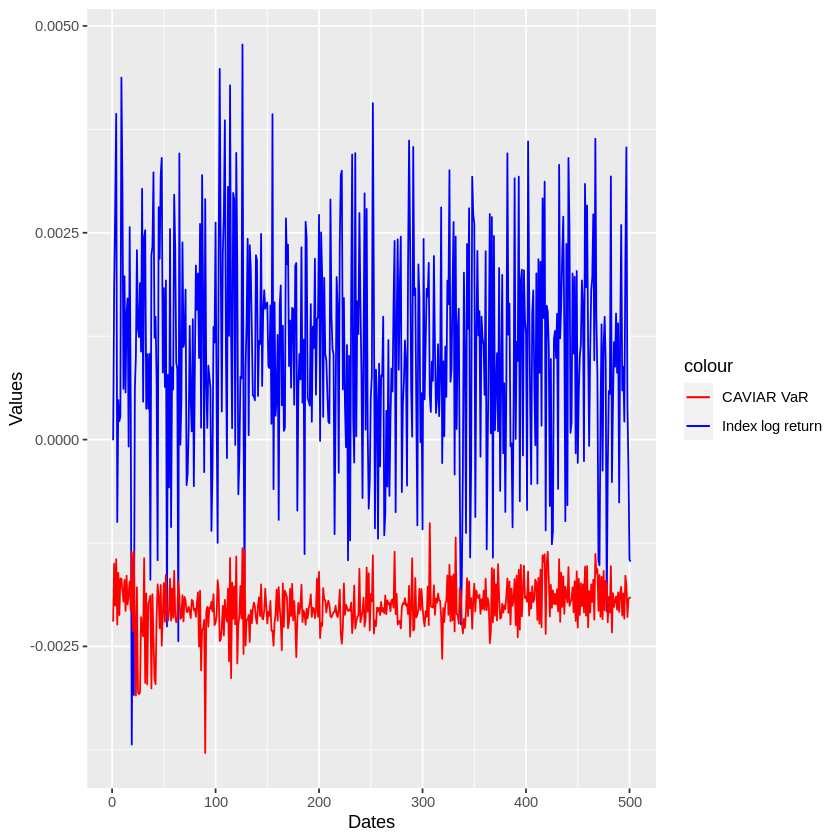

In [ ]:
# ggplot() +
#   geom_line(aes(x = 1:501, y = tail(sim_norm$garch,501), col = "Index log return")) +
#   geom_line(aes(x = 1:501, y = -1*varpredict, col = "CAVIAR VaR"))+
#   scale_color_manual(values=c("#ff0000", "#0000ff")) +
#   ylab("Values")+
#   xlab("Dates")

#### Fit on the simulation data

In [ ]:
dfall_norm_caviar <- data.frame()
dfall_snorm_caviar <- data.frame()
dfall_std_caviar <- data.frame()
thetas <- c(0.01,0.05,0.1)
datasets <- c('norm','snorm','std')

for(d in datasets){
  if(d == 'norm'){
    data = sim_norm
  }else if(d=='snorm'){
    data = sim_snorm
  }else{
    data = sim_std
  }
  for(theta in thetas){
    varpredict <- rollapplyr(data$garch, length(data$garch) - 500, caviarOptim, 1, theta, predict = 1) %>% lag
    varpredict <- (-varpredict)

    p <- sum(tail(data$garch,500)<varpredict[1:(length(varpredict)-1)])/500
    #when plug into the function, we need to convert VaR to be negative
    ls <- BacktestVaR(tail(data$garch,500), varpredict[1:(length(varpredict)-1)], theta)
    uc_p <- ls$LRuc['Pvalue']
    cc_p <- ls$LRcc['Pvalue']
    df_caviar <- data.frame(p,uc_p,cc_p)
    rownames(df_caviar) <- theta
    if(d == 'norm'){
      dfall_norm_caviar <- rbind(dfall_norm_caviar,df_caviar)
    }else if(d=='snorm'){
      dfall_snorm_caviar <- rbind(dfall_snorm_caviar,df_caviar)
    }else{
      dfall_std_caviar <- rbind(dfall_std_caviar,df_caviar)
    }
  }
}
write.csv(dfall_norm_caviar,"dfall_norm_caviar.csv")
write.csv(dfall_snorm_caviar,"dfall_snorm_caviar.csv")
write.csv(dfall_std_caviar,"dfall_std_caviar.csv")

In [ ]:
dfall_norm_caviar

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.014,0.3965697,0.006286847
0.05,0.048,0.8363894,0.012189165
0.1,0.100,1.0000000,0.351155458


In [ ]:
dfall_snorm_caviar

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.008,0.64143491,0.8686988
0.05,0.040,0.28847909,0.2804088
0.1,0.078,0.08931157,0.1251179


In [ ]:
dfall_std_caviar

,p,uc_p,cc_p
,<dbl>,<dbl>,<dbl>
0.01,0.012,0.6630163,0.8453841
0.05,0.058,0.4229371,0.7029190
0.1,0.108,0.5555580,0.8383347


In [ ]:
run_caviar_1 <- function(data,model){
    dfall_caviar <- data.frame()
    thetas <- c(0.01,0.05,0.1)
    test_size <- length(data)-1000

    for(theta in thetas){
      varpredict <- rollapplyr(data, 1000, caviarOptim, model, theta, predict = 1) %>% lag
      varpredict <- (-varpredict)

      p <- sum(tail(data,test_size)<varpredict[1:(length(varpredict)-1)])/test_size
      #when plug into the function, we need to convert VaR to be negative
      ls <- BacktestVaR(tail(data,test_size), varpredict[1:(length(varpredict)-1)], theta)
      uc_p <- ls$LRuc['Pvalue']
      cc_p <- ls$LRcc['Pvalue']
      dfall_caviar <- rbind(dfall_caviar,cbind(p,uc_p,cc_p))
    }
    return(dfall_caviar)
  }

In [ ]:
get_caviar_var <- function(data,model){
    dfall_caviar <- data.frame()
    thetas <- c(0.01,0.05,0.1)
    test_size <- length(data)-1000
    VaR <- list(`0.01` = NULL, `0.05` = NULL, `0.1` = NULL)
    for(theta in thetas){
      varpredict <- rollapplyr(data, 1000, caviarOptim, model, theta, predict = 1) %>% lag
      VaR[[as.character(theta)]] <- (-varpredict)
    }
    return(VaR)
}

In [ ]:
#fit on simulation data with the normal conditional distribution
var <- get_caviar_var(sim_norm$garch,1)
write.csv(var, 'var_sim_norm_caviar_1.csv')

var <- get_caviar_var(sim_norm$garch,2)
write.csv(var, 'var_sim_norm_caviar_2.csv')

var <- get_caviar_var(sim_norm$garch,3)
write.csv(var, 'var_sim_norm_caviar_3.csv')

var <- get_caviar_var(sim_norm$garch,4)
write.csv(var, 'var_sim_norm_caviar_4.csv')

In [ ]:
#fit on simulation data with the skewed normal conditional distribution
var <- get_caviar_var(sim_snorm$garch,1)
write.csv(var, 'var_sim_snorm_caviar_1.csv')

var <- get_caviar_var(sim_snorm$garch,2)
write.csv(var, 'var_sim_snorm_caviar_2.csv')

var <- get_caviar_var(sim_snorm$garch,3)
write.csv(var, 'var_sim_snorm_caviar_3.csv')

var <- get_caviar_var(sim_snorm$garch,4)
write.csv(var, 'var_sim_snorm_caviar_4.csv')

In [ ]:
#fit on simulation data with the student t conditional distribution
var <- get_caviar_var(sim_std$garch,1)
write.csv(var, 'var_sim_std_caviar_1.csv')

var <- get_caviar_var(sim_std$garch,2)
write.csv(var, 'var_sim_std_caviar_2.csv')

var <- get_caviar_var(sim_std$garch,3)
write.csv(var, 'var_sim_std_caviar_3.csv')

var <- get_caviar_var(sim_std$garch,4)
write.csv(var, 'var_sim_std_caviar_4.csv')

#### Fit on the empirical data

In [ ]:
#fit on AAPL stock returns
var <- get_caviar_var(time_series4,1)
write.csv(var, 'var_aapl_caviar_1.csv')

var <- get_caviar_var(time_series4,2)
write.csv(var, 'var_aapl_caviar_2.csv')

var <- get_caviar_var(time_series4,3)
write.csv(var, 'var_aapl_caviar_3.csv')

var <- get_caviar_var(time_series4,4)
write.csv(var, 'var_aapl_caviar_4.csv')

In [ ]:
#fit on ALAR stock returns
var <- get_caviar_var(time_series5,1)
write.csv(var, 'var_alar_caviar_1.csv')

var <- get_caviar_var(time_series5,2)
write.csv(var, 'var_alar_caviar_2.csv')

var <- get_caviar_var(time_series5,3)
write.csv(var, 'var_alar_caviar_3.csv')

var <- get_caviar_var(time_series5,4)
write.csv(var, 'var_alar_caviar_4.csv')

In [ ]:
#fit on SMTC stock returns
var <- get_caviar_var(time_series6,1)
write.csv(var, 'var_smtc_caviar_1.csv')

var <- get_caviar_var(time_series6,2)
write.csv(var, 'var_smtc_caviar_2.csv')

var <- get_caviar_var(time_series6,3)
write.csv(var, 'var_smtc_caviar_3.csv')

var <- get_caviar_var(time_series6,4)
write.csv(var, 'var_smtc_caviar_4.csv')

In [ ]:
dfall_caviar <- run_caviar_1(time_series4,1)
data_name <- 'aapl'
write.csv(dfall_caviar,paste0("dfall_,",data_name,"_caviar1.csv"))

dfall_caviar <- run_caviar_1(time_series5,1)
data_name <- 'alar'
write.csv(dfall_caviar,paste0("dfall_,",data_name,"_caviar1.csv"))

dfall_caviar <- run_caviar_1(time_series6,1)
data_name <- 'smtc'
write.csv(dfall_caviar,paste0("dfall_,",data_name,"_caviar1.csv"))

### Model 3: Hybrid-QRNN Model

#### Get the Optimal Configuration
use the first 300 data to fit the three types of models and use BIC to determine their specifications

In [ ]:
#get the best configurations for the 3 Garch-type models (EGARCH, APARCH, EWMA (choosing p,q from 1,2, conditional distributions from normal to student t to skewed noraml)
get_best_spec <- function(model,data,start,end){
  # Vectorize the combinations of p, q, and dist
  pq_dist_combinations <- expand.grid(p = 1:2, q = 1:2, dist = c('norm', 'snorm', 'std'))

  min_bic <- Inf
  best <- NULL
  for(i in seq(12)){
    spec <- ugarchspec(variance.model = list(model = model, garchOrder = c(pq_dist_combinations[i,1], pq_dist_combinations[i,2])),
                       mean.model = list(armaOrder = c(1, 0)), distribution.model = as.character(pq_dist_combinations[i,3]))
    fit <- ugarchfit(data = data[start:end], spec = spec, solver = 'hybrid')
    bic <- infocriteria(fit)[2] # Return BIC
    if(bic < min_bic){
      min_bic <- bic
      best <- i
    }
  }

  # Find the combination with minimum BIC
  opt_combination <- pq_dist_combinations[best, ]

  # Extract optimal parameters
  opt_p <- opt_combination$p
  opt_q <- opt_combination$q
  opt_dist <- opt_combination$dist

  # Construct the best specification
  spec_best <- ugarchspec(variance.model = list(model = model, garchOrder = c(opt_p, opt_q)),
                          mean.model = list(armaOrder = c(1, 0)), distribution.model = as.character(opt_dist))


  return(spec_best)
}

In [ ]:
#get the optimal configuration for the QRNN model (with or without the two previous returns, with 2 or 5 or 10 nodes)
get_opt <- function(data,mat,tau){
  loss <- c()
  grid <- c('wo 2','wo 5','wo 10','w 2','w 5','w10')
  fit <- qrnn.fit(mat[1:600,], as.matrix(data[301:900]), n.hidden=2, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(mat[601:700,],fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  fit <- qrnn.fit(mat[1:600,], as.matrix(data[301:900]), n.hidden=5, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(mat[601:700,],fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  fit <- qrnn.fit(mat[1:600,], as.matrix(data[301:900]), n.hidden=10, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(mat[601:700,],fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  fit <- qrnn.fit(cbind(mat[1:600,],lags(data,1)[300:899,2],lags(data,2)[299:898,2]), as.matrix(data[301:900]), n.hidden=2, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(cbind(mat[601:700,],lags(data,1)[900:999,2],lags(data,2)[899:998,2]),fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  fit <- qrnn.fit(cbind(mat[1:600,],lags(data,1)[300:899,2],lags(data,2)[299:898,2]), as.matrix(data[301:900]), n.hidden=5, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(cbind(mat[601:700,],lags(data,1)[900:999,2],lags(data,2)[899:998,2]),fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  fit <- qrnn.fit(cbind(mat[1:600,],lags(data,1)[300:899,2],lags(data,2)[299:898,2]), as.matrix(data[301:900]), n.hidden=10, w=NULL, tau=tau,penalty=0.01)
  pred <- qrnn.predict(cbind(mat[601:700,],lags(data,1)[900:999,2],lags(data,2)[899:998,2]),fit)
  pinball <- loss(pred, data[901:1000], loss.type = list(name="pinball",tau=tau))
  loss <- append(loss, sum(pinball))

  return(grid[which.min(loss)])
}

#### Generated Garch-type Forecasts as Inputs to QRNN

In [ ]:
get_qrnn_inputs <- function(data, data_name){


### 1min
opt_ap <- get_best_spec('apARCH',sim_snorm$garch,1,300)
opt_eg <- get_best_spec('eGARCH',sim_snorm$garch,1,300)
opt_ig <- get_best_spec('iGARCH',sim_snorm$garch,1,300)

#corresponding to the inputs for fitting quantile 0.01,0.05,0.1
mat_1 <- c()
mat_2 <- c()
mat_3 <- c()
#firstly trained the neural network model using the 748 samples in the first 1000 training set

# Initializes the progress bar
n_iter <- 700
pb <- txtProgressBar(min = 0,      # Minimum value of the progress bar
                max = n_iter, # Maximum value of the progress bar
                style = 3,    # Progress bar style (also available style = 1 and style = 2)
                width = 50,   # Progress bar width. Defaults to getOption("width")
                char = "=")

for(j in 1:n_iter){
    t <- try(fit <- ugarchfit(data = data[j:(j+299)], spec = opt_ap,solver='hybrid'))
    if("try-error" %in% class(t)){
      mat_1 <- append(mat_1,mat_1[length(mat_1)-3])
      mat_2 <- append(mat_2,mat_2[length(mat_2)-3])
      mat_3 <- append(mat_3,mat_3[length(mat_3)-3])
    }else{
      mat_1 = append(mat_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
      mat_2 = append(mat_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
      mat_3 = append(mat_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
    }

    t <- try(fit <- ugarchfit(data = data[j:(j+299)], spec = opt_eg,solver='hybrid'))
    if("try-error" %in% class(t)){
      mat_1 <- append(mat_1,mat_1[length(mat_1)-3])
      mat_2 <- append(mat_2,mat_2[length(mat_2)-3])
      mat_3 <- append(mat_3,mat_3[length(mat_3)-3])
    }else{
      mat_1 = append(mat_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
      mat_2 = append(mat_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
      mat_3 = append(mat_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
    }

    t <- try(fit <- ugarchfit(data = data[j:(j+299)], spec = opt_ig,solver='hybrid'))
    if("try-error" %in% class(t)){
      mat_1 <- append(mat_1,mat_1[length(mat_1)-3])
      mat_2 <- append(mat_2,mat_2[length(mat_2)-3])
      mat_3 <- append(mat_3,mat_3[length(mat_3)-3])
    }else{
      mat_1 = append(mat_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
      mat_2 = append(mat_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
      mat_3 = append(mat_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
    }

  setTxtProgressBar(pb, j)
}
close(pb)


mat_1 <- matrix(mat_1,ncol=3,byrow=TRUE)
mat_2 <- matrix(mat_2,ncol=3,byrow=TRUE)
mat_3 <- matrix(mat_3,ncol=3,byrow=TRUE)

write.csv(mat_1,paste0('mat_1_',data_name,'.csv'))
write.csv(mat_2,paste0('mat_2_',data_name,'.csv'))
write.csv(mat_3,paste0('mat_3_',data_name,'.csv'))


#corresponding to the inputs for fitting quantile 0.01,0.05,0.1
mat_test_1 <- c()
mat_test_2 <- c()
mat_test_3 <- c()

#secondly refit the garch-type models to generate inputs for the test data set
n <- length(data)

# Initializes the progress bar
# n_iter <- n-1000

pb <- txtProgressBar(min = 1001,      # Minimum value of the progress bar
                max = n, # Maximum value of the progress bar
                style = 3,    # Progress bar style (also available style = 1 and style = 2)
                width = 50,   # Progress bar width. Defaults to getOption("width")
                char = "=")

for(j in seq(1001,n)){
  #print(j)

  t <- try(fit <- ugarchfit(data = data[(j-300):(j-1)], spec = opt_ap, solver = 'hybrid'))
  if("try-error" %in% class(t)){
    mat_test_1 <- append(mat_test_1,mat_test_1[length(mat_test_1)-3])
    mat_test_2 <- append(mat_test_2,mat_test_2[length(mat_test_2)-3])
    mat_test_3 <- append(mat_test_3,mat_test_3[length(mat_test_3)-3])
  }else{
    mat_test_1 <- append(mat_test_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
    mat_test_2 <- append(mat_test_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
    mat_test_3 <- append(mat_test_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
  }

  t <- try(fit <- ugarchfit(data = data[(j-300):(j-1)], spec = opt_eg, solver = 'hybrid'))
  if("try-error" %in% class(t)){
    mat_test_1 <- append(mat_test_1,mat_test_1[length(mat_test_1)-3])
    mat_test_2 <- append(mat_test_2,mat_test_2[length(mat_test_2)-3])
    mat_test_3 <- append(mat_test_3,mat_test_3[length(mat_test_3)-3])
  }else{
    mat_test_1 <- append(mat_test_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
    mat_test_2 <- append(mat_test_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
    mat_test_3 <- append(mat_test_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
  }

  t <- try(fit <- ugarchfit(data = data[(j-300):(j-1)], spec = opt_ig, solver = 'hybrid'))
  if("try-error" %in% class(t)){
    mat_test_1 <- append(mat_test_1,mat_test_1[length(mat_test_1)-3])
    mat_test_2 <- append(mat_test_2,mat_test_2[length(mat_test_2)-3])
    mat_test_3 <- append(mat_test_3,mat_test_3[length(mat_test_3)-3])
  }else{
    mat_test_1 <- append(mat_test_1, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.01)[1])
    mat_test_2 <- append(mat_test_2, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.05)[1])
    mat_test_3 <- append(mat_test_3, -quantile(ugarchforecast(fit, n.ahead=1),probs=0.1)[1])
  }

  setTxtProgressBar(pb, j)
}
close(pb)

mat_test_1 <- matrix(mat_test_1,ncol=3,byrow=TRUE)
mat_test_2 <- matrix(mat_test_2,ncol=3,byrow=TRUE)
mat_test_3 <- matrix(mat_test_3,ncol=3,byrow=TRUE)

write.csv(mat_test_1,paste0('mat_test_1_',data_name,'.csv'))
write.csv(mat_test_2,paste0('mat_test_2_',data_name,'.csv'))
write.csv(mat_test_3,paste0('mat_test_3_',data_name,'.csv'))

}

#### Get the Best Configuration for the QRNN model for Different Quantiles and Fit the Models

In [ ]:
df_nn = data.frame()
tau = 0.01

opt_model <- get_opt(data,mat_1,tau)
print(opt_model)

In [ ]:
#fit the models based on the optimal model configurations
fit <- qrnn.fit(mat_1, as.matrix(data[301:1000]), n.hidden=5, w=NULL, tau=tau,penalty=0.01)

nn_VaR <- qrnn.predict(mat_test_1,fit)
n <- length(data)
p <- sum(data[1001:n]<nn_VaR)/(n-1000)

#when plug into the function, we need to convert VaR to be negative
ls <- BacktestVaR(data[1001:n], nn_VaR, tau)
uc_p <- ls$LRuc['Pvalue']
cc_p <- ls$LRcc['Pvalue']
df_nn <- rbind(df_nn,cbind(p,uc_p,cc_p))

In [ ]:
tau = 0.05

opt_model <- get_opt(data,mat_2,tau)
fit <- qrnn.fit(mat_2, as.matrix(data[301:1000]), n.hidden=5, w=NULL, tau=tau,penalty=0.01)

nn_VaR <- qrnn.predict(mat_test_2,fit)
n <- length(data)
p <- sum(data[1001:n]<nn_VaR)/(n-1000)

#when plug into the function, we need to convert VaR to be negative
ls <- BacktestVaR(data[1001:n], nn_VaR, tau)
uc_p <- ls$LRuc['Pvalue']
cc_p <- ls$LRcc['Pvalue']
df_nn <- rbind(df_nn,cbind(p,uc_p,cc_p))

In [ ]:
tau = 0.1

opt_model <- get_opt(data,mat_3,tau)
fit <- qrnn.fit(mat_1, as.matrix(data[301:1000]), n.hidden=5, w=NULL, tau=tau,penalty=0.01)

nn_VaR <- qrnn.predict(mat_test_3,fit)
n <- length(data)
p <- sum(data[1001:n]<nn_VaR)/(n-1000)

#when plug into the function, we need to convert VaR to be negative
ls <- BacktestVaR(data[1001:n], nn_VaR, tau)
uc_p <- ls$LRuc['Pvalue']
cc_p <- ls$LRcc['Pvalue']
df_nn <- rbind(df_nn,cbind(p,uc_p,cc_p))

#### Get the Forecasted VaR from QRNN

In [ ]:
get_qrnn_var <- function(data,ind,nodes,mat_1,mat_2,mat_3,test_mat_1,test_mat_2,test_mat_3){

  n <- length(data)
  thetas <- c(0.01,0.05,0.1)
  VaR <- list(`0.01` = NULL, `0.05` = NULL, `0.1` = NULL)

  if(ind[1]){
    fit <- qrnn.fit(cbind(mat_1[1:700,],lags(data,1)[300:999,2],lags(data,2)[299:998,2]), as.matrix(data[301:1000]), n.hidden=nodes[1], w=NULL, tau=thetas[1],penalty=0.01)
    nn_VaR <- qrnn.predict(cbind(test_mat_1,lags(data,1)[1000:(n-1),2],lags(data,2)[999:(n-2),2]),fit)
    VaR[[as.character(thetas[1])]] <- nn_VaR
  }else{
    fit <- qrnn.fit(cbind(mat_1[1:700,]), as.matrix(data[301:1000]), n.hidden=nodes[1], w=NULL, tau=thetas[1],penalty=0.01)
    nn_VaR <- qrnn.predict(test_mat_1,fit)
    VaR[[as.character(thetas[1])]] <- nn_VaR
  }


  if(ind[2]){
    fit <- qrnn.fit(cbind(mat_2[1:700,],lags(data,1)[300:999,2],lags(data,2)[299:998,2]), as.matrix(data[301:1000]), n.hidden=nodes[2], w=NULL, tau=thetas[2],penalty=0.01)
    nn_VaR <- qrnn.predict(cbind(test_mat_2,lags(data,1)[1000:(n-1),2],lags(data,2)[999:(n-2),2]),fit)
    VaR[[as.character(thetas[2])]] <- nn_VaR
  }else{
    fit <- qrnn.fit(cbind(mat_2[1:700,]), as.matrix(data[301:1000]), n.hidden=nodes[2], w=NULL, tau=thetas[2],penalty=0.01)
    nn_VaR <- qrnn.predict(test_mat_2,fit)
    VaR[[as.character(thetas[2])]] <- nn_VaR
  }


  if(ind[3]){
    fit <- qrnn.fit(cbind(mat_3[1:700,],lags(data,1)[300:999,2],lags(data,2)[299:998,2]), as.matrix(data[301:1000]), n.hidden=nodes[3], w=NULL, tau=thetas[3],penalty=0.01)
    nn_VaR <- qrnn.predict(cbind(test_mat_3,lags(data,1)[1000:(n-1),2],lags(data,2)[999:(n-2),2]),fit)
    VaR[[as.character(thetas[3])]] <- nn_VaR
  }else{
    fit <- qrnn.fit(cbind(mat_3[1:700,]), as.matrix(data[301:1000]), n.hidden=nodes[3], w=NULL, tau=thetas[3],penalty=0.01)
    nn_VaR <- qrnn.predict(test_mat_3,fit)
    VaR[[as.character(thetas[3])]] <- nn_VaR
  }
  return(VaR)
}

In [ ]:
#here we use the inputs from the normal conditional distribution as an example. should fit other 5 data sets
mat_1 <- as.matrix(read.csv('mat_1_norm.csv')[,2:4])
mat_2 <- as.matrix(read.csv('mat_2_norm.csv')[,2:4])
mat_3 <- as.matrix(read.csv('mat_3_norm.csv')[,2:4])
test_mat_1 <- as.matrix(read.csv('mat_test_1_norm.csv')[,2:4])
test_mat_2 <- as.matrix(read.csv('mat_test_2_norm.csv')[,2:4])
test_mat_3 <- as.matrix(read.csv('mat_test_3_norm.csv')[,2:4])
var <- get_qrnn_var(sim_norm$garch,c(TRUE,TRUE,TRUE),c(2,2,2),mat_1,mat_2,mat_3,test_mat_1,test_mat_2,test_mat_3)
write.csv('VaR_norm_qrnn.csv')

ggplot() +
  geom_line(aes(x = 1:500, y = tail(sim_norm$garch,500), col = "Index log return")) +
  geom_line(aes(x = 1:500, y = var$`0.01`, col = "Qrnn VaR"))+
  scale_color_manual(values=c("#ff0000", "#0000ff")) +
  ylab("Values")+
  xlab("Dates")

### Multiple Testing: Adjusted the p-values by the Storey's approach of Benjamin-Hochberg Method

In [ ]:
lambda <- 0.5
n <- length(pvals)
candsum <- sum(pvals > lambda)
pi0 <- (candsum + 1) / ((1 - lambda) * n)
padj <- p.adjust(pvals, method = "BH", n = length(pvals)) * pi0

padj <- matrix(padj, nrow=18)

write.csv(padj,'padj.csv')

### Calculate the pinball losses of the fitted models using the forecasted VaR

In [ ]:
#mannually loop through the simulation data sets and change the corresponding names for the excels
#here is just an example using the skewed normal conditional distribution
m1 <- list(`norm` = NULL, `snorm` = NULL, `std` = NULL)
m2 <- list(`norm` = NULL, `snorm` = NULL, `std` = NULL)
m3 <- list(`norm` = NULL, `snorm` = NULL, `std` = NULL)

data <- sim_snorm$garch
d <- 'snorm'

df <- read.csv('VaR_sim_snorm_ap.csv')
# df <- read.csv('VaR_sim_snorm_caviar_1.csv')[1:500,]
# df <- read.csv('VaR_sim_snorm_caviar_2.csv')[1:500,]
# df <- read.csv('VaR_sim_snorm_caviar_3.csv')[1:500,]
# df <- read.csv('VaR_sim_snorm_caviar_4.csv')[1:500,]
# df <- read.csv('VaR_snorm_qrnn.csv')

pinball <- loss(df$X0.01, data[1001:length(data)], loss.type = list(name="pinball",tau=0.01))
m1[[d]] <- append(m1[[d]],sum(pinball))

pinball <- loss(df$X0.05, data[1001:length(data)], loss.type = list(name="pinball",tau=0.05))
m2[[d]] <- append(m2[[d]],sum(pinball))

pinball <- loss(df$X0.1, data[1001:length(data)], loss.type = list(name="pinball",tau=0.1))
m3[[d]] <- append(m3[[d]],sum(pinball))

#each of the matrices will be of 6 rows and 3 columns
write.csv(m1,'pinball losses for snorm at quantile 0.01.csv')
write.csv(m2,'pinball losses for snorm at quantile 0.05.csv')
write.csv(m3,'pinball losses for snorm at quantile 0.1.csv')

### Tail-risk Managed Asset(Rebalancing Strategy)
We want to test the performance of the strategy from 2023-03-01 to 2024-03-01

In [ ]:
#here we take SMTC stock returns as an example. similar procedures could be applied to the other two stocks
smtc_mon_ret <- c()

start_date <- as.Date("2023-03-01")
end_date <- as.Date("2024-03-01")

monthly_dates <- seq(from = start_date, to = end_date, by = "month")
last_of_month <- (monthly_dates - days(1))[2:13]
monthly_dates <- monthly_dates[1:12]

for(i in 1:12){
  start = monthly_dates[i]
  end = last_of_month[i]
  options("getSymbols.warning4.0"=FALSE)
  options("getSymbols.yahoo.warning"=FALSE)
  # Downloading Apple price using quantmod

  getSymbols("SMTC", from = start,
             to = end,warnings = FALSE,
             auto.assign = TRUE)

  time_series <- SMTC$SMTC.Adjusted
  ret <- dailyReturn(time_series, type = 'arithmetic')
  smtc_mon_ret  <- append(smtc_mon_ret , tail(cumprod(as.vector(ret)+1)-1,1))
}

options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("SMTC", from = '2023-03-01',
           to = "2024-03-01",warnings = FALSE,
           auto.assign = TRUE)

nn_VaR <- read.csv('var_smtc_qrnn.csv')$`X0.05`[47:298]
nn_VaR <- data.frame(cbind(tail(rownames(data.frame(SMTC)),252),nn_VaR))
nn_VaR$V1 <- substr(nn_VaR$V1,1,7)

nn_VaR <- nn_VaR %>%
  group_by(V1)%>%
  slice(1)%>%
  ungroup()

var <- as.numeric(nn_VaR$nn_VaR)

numer = sum((smtc_mon_ret-mean(smtc_mon_ret))**2)
trans_ret <- smtc_mon_ret/(-var*sqrt(22))
denom = sum((trans_ret-mean(trans_ret))**2)
c = sqrt(numer/denom)

rebal_ret <- trans_ret*c
df <- data.frame(cbind(rebal_ret, smtc_mon_ret))
lmm <- lm(rebal_ret~smtc_mon_ret,data=df)
summary(lmm)

If the alpha in the regression is significantly positive, then it means that our strategy is effective at increasing the Sharpe Ratio compared to the buy-and-hold strategy.

#### Drawing the Cumulative Returns Curve

In [ ]:
ret_mon <- smtc_mon_ret

# Calculate cumulative returns
rebal_cum_ret <- cumprod(1 + rebal_ret/100)
cum_ret <- cumprod(1 + ret_mon/100)

# Calculate drawdowns

dates <- as.Date(c('20230301', '20230401', '20230501', '20230601', '20230701',
                  '20230801', '20230901', '20231001', '20231101', '20231201',
                  '20240101', '20240201'), format = "%Y%m%d")

# Create a data frame for plotting
data <- data.frame(Date = dates,
                   rebal_cum_ret = rebal_cum_ret,
                   cum_ret = cum_ret)

# Plotting both curves
# Cumulative Returns plot
Sys.setlocale("LC_TIME", "English")

p1 <- ggplot(data) +
  geom_line(aes(x = Date, y = rebal_cum_ret,color = "Rebalanced by VaR")) +
  geom_line(aes(x = Date, y = cum_ret,color="Buy-and-hold"))+
  ggtitle("Cumulative Return Curve of SMTC") +
  ylab("Cumulative Return") +
  theme_classic()+
      scale_color_manual(
        name="Strategies",
    values = c("Rebalanced by VaR" = "blue", "Buy-and-hold" = "red")
  )

# Print plots
print(p1)
# print(p2)
ggsave('cum_ret_smtc.png',p1)